In [1]:
import yfinance as yf
import pandas as pd 
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import copy 
import random 
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Neural Network-Based Dollar-Neutral Trading Strategy

**Course**: DSA5205 - Data Science in Quantitative Finance  
**Institution**: National University of Singapore

## Notebook Overview

This notebook implements and evaluates three neural network architectures for systematic trading:

1. **Data Loading**: US large-cap stocks (22 tickers) + macro indicators (7 series)
2. **Model Training**: MLP (baseline), LSTM (temporal), CNN-LSTM (hybrid)
3. **Backtesting**: Realistic transaction costs (10 bps), dollar-neutral constraint
4. **Evaluation**: Comprehensive performance metrics, statistical significance, regime analysis

**Key Results** (Out-of-Sample 2015-2025):
- CNN-LSTM Sharpe: **0.970** vs SPY: 0.874
- Max Drawdown: **-21.02%** vs SPY: -31.83% (34% lower)
- Statistical Significance: **NOT significant** (p=0.472, bootstrap N=10,000)

**Methodology Highlights**:
- Time-respecting validation (strict chronological splits)
- Domain-expert hyperparameters (validated via Bayesian optimization)
- 5-model ensemble averaging
- Yearly retraining to adapt to regime changes

## 1. Setup and Configuration

Initialize random seeds for reproducibility and import required libraries.

## 2. Data Loading and Preprocessing

Load stock price data for 22 US large-cap stocks across 5 sectors:
- **Technology**: AAPL, MSFT, GOOGL, AMZN, NVDA
- **Financials**: JPM, BAC, GS, C
- **Healthcare**: JNJ, PFE, MRK, UNH
- **Energy**: XOM, CVX, COP, SLB
- **Industrials/Consumer**: BA, CAT, MMM, DIS, NKE

**Data Specification**:
- Source: Yahoo Finance (yfinance)
- Period: January 2008 - October 2025 (17+ years)
- Frequency: Weekly (Friday close)
- Treatment: Adjusted for splits and dividends

In [2]:
tickers = [
    # Mega-cap Tech (keep for comparison)
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA",
    # Financials
    "JPM", "BAC", "GS", "C", 
    # Healthcare
    "JNJ", "PFE", "MRK", "UNH", 
    # Energy
    "XOM", "CVX", "COP", "SLB",
    # Industrials / Consumer
    "BA", "CAT", "MMM", "DIS", "NKE",    
]

def fetch_stock_data(tickers, start_date="2008-01-01", end_date="2025-10-01"): 
    return yf.download(tickers, start=start_date, end=end_date) 

yfinance_df  = fetch_stock_data(tickers).dropna(how='any',axis=1).dropna(how='any',axis=0)


/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/2975323493.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  22 of 22 completed


## 4. Backtesting with Transaction Costs

Implement realistic backtesting framework:

**Transaction Cost Model**:
- Rate: 10 basis points (0.001) per trade
- Applied to turnover (sum of absolute weight changes)
- Industry-standard assumption for liquid large-caps

**Performance Metrics Calculated**:
1. **Return metrics**: Annualized return (gross & net), volatility
2. **Risk-adjusted**: Sharpe ratio, Sort ino ratio, Calmar ratio
3. **Risk metrics**: Maximum drawdown, win rate
4. **Trading metrics**: Average turnover, total TC cost, TC impact on Sharpe

**Benchmark**: SPY ETF (S&P 500 buy-and-hold) over identical period

## 5. Performance Visualization

Generate publication-quality visualizations for result analysis:

**Plot Set 1** (performance_plots_1.png):
1. Cumulative returns: All strategies vs SPY benchmark
2. CNN-LSTM vs SPY focused comparison
3. Rolling 52-week Sharpe ratio evolution
4. Drawdown analysis over time

**Plot Set 2** (performance_plots_2.png):
1. Weekly returns distribution (CNN-LSTM vs SPY)
2. Portfolio turnover over time (12-week moving average)
3. Transaction cost impact on Sharpe ratios
4. Cumulative transaction costs

**Plot Set 3** (oos_r2_analysis.png):
1. Rolling out-of-sample R² (52-week window)
2. Overall OOS R² by model

**Key Insight**: Negative R² values indicate models don't predict individual stock returns well—performance stems from portfolio construction (cross-sectional allocation) rather than forecasting accuracy.

## 6. Statistical Significance and Regime Analysis

Assess robustness through rigorous statistical testing:

**Bootstrap Confidence Intervals** (N=10,000):
- Construct 95% confidence intervals for Sharpe ratios
- Test statistical significance of CNN-LSTM vs SPY difference
- Account for finite-sample uncertainty

**Regime-Specific Analysis**:
1. **Pre-COVID Bull** (Oct 2015 - Feb 2020): Strategy performance in stable growth markets
2. **COVID Crisis** (Mar 2020 - Dec 2020): Performance during market stress
3. **Recovery & Rates** (Jan 2021 - Sep 2025): Behavior in volatile rate environment

**Year-over-Year Analysis**:
- Annual return comparison (2016-2025)
- Win rate calculation (years outperforming SPY)

**Critical Finding**: Despite point estimate outperformance (Sharpe 0.970 vs 0.874), wide confidence intervals and p=0.472 indicate the difference is **NOT statistically significant** at conventional levels. Performance is better characterized as comparable to passive indexing with enhanced risk management.

# Model Architecture and Training Setup

This section defines:
1. **Neural Network Architectures**: MLP (baseline), LSTM (temporal), CNN-LSTM (hybrid)
2. **Loss Function**: Sharpe ratio maximization with transaction cost penalty
3. **Training Infrastructure**: Rolling window validation, ensemble averaging, early stopping
4. **Domain-Expert Hyperparameters**: Validated in Section 8 of FINAL_REPORT.md
   - CNN channels: 16 (cross-sectional feature learning)
   - Dropout: 0.1 (regularization with BatchNorm)
   - TC Lambda: 0.1 (transaction cost penalty weight)
   - Learning rate: 1e-4 (Adam optimizer)

**Key Methodological Choices**:
- Dollar-neutral constraint (zero market beta exposure)
- 25-week lookback window (≈6 months of price history)
- Yearly retraining to adapt to regime changes
- 5-model ensemble to reduce variance

In [3]:
# Get Monday open and Friday close within each week
weekly_open = yfinance_df["Open"].resample("W-FRI").first()
weekly_close = yfinance_df["Close"].resample("W-FRI").last()

# Compute weekly return: Monday open → Friday close
y = (weekly_close / weekly_open - 1).shift(-1).dropna()

# Weekly features (Friday snapshot)
X = yfinance_df.resample("W-FRI").last().dropna()

tickers = ['IEF', 'TLT', 'SHY', 'GLD', 'USO', '^VIX', 'DX-Y.NYB']  # DXY ticker on Yahoo
macro_data = yf.download(tickers, start='2010-01-01', end='2025-10-31')['Close']
macro_weekly = macro_data.resample("W-FRI").last().dropna()
X = pd.concat([X, macro_weekly], axis=1).dropna()

# Align features and target
common = X.index.intersection(y.index)
X = X.loc[common]
y = y.loc[common]

# ============================================================================
# STATIC HYPERPARAMETERS (Domain-Expert Selection)
# ============================================================================
# These parameters were validated in Section 8 of FINAL_REPORT.md
# Static domain-expert selection outperformed both standard and robust optimization
STATIC_CNN_CHANNELS = 16
STATIC_DROPOUT = 0.1
STATIC_TC_LAMBDA = 0.1
STATIC_LR = 0.0001

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            padding=(kernel_size-1)*dilation, dilation=dilation
        )
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act1 = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Conv1d(in_channels, out_channels, 1) \
                        if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        # x: (batch, channels, seq_len)
        out = self.conv1(x)
        out = out[:, :, :x.size(2)]  # crop to original seq_len
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout(out)
        res = self.residual(x)
        return out + res

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        # ensure y is always 2D: (num_samples, n_outputs)
        if self.y.ndim == 1:
            self.y = self.y[:, None]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def make_dollar_neutral(x):
    # x: (batch, n_outputs)
    return x - x.mean(dim=1, keepdim=True)

class CNNLSTM2D(nn.Module):
    """CNN-LSTM with Static (Domain-Expert) hyperparameters"""
    def __init__(self, n_features, n_outputs, lookback):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels=1,       
            out_channels=STATIC_CNN_CHANNELS,  # 16 (domain-expert)
            kernel_size=(1, 5),  
            padding=(0, 2)       
        )
        self.bn = nn.BatchNorm2d(STATIC_CNN_CHANNELS)
        self.act = nn.GELU()

        self.lstm = nn.LSTM(
            input_size=n_features + STATIC_CNN_CHANNELS,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            dropout=STATIC_DROPOUT  # 0.1 (domain-expert)
        )
        self.fc = nn.Linear(64, n_outputs)
        self.dropout = nn.Dropout(STATIC_DROPOUT)  # 0.1 (domain-expert)

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        B, T, F = x.shape

        # Conv2d expects (B, C, H, W) → here H=1, W=features
        x_in = x.unsqueeze(1)  # (B, 1, T, F)
        x_cnn = self.act(self.bn(self.conv(x_in)))  # (B, 16, T, F)
        # Pool along features (optional)
        x_cnn = x_cnn.mean(dim=-1)  # (B, 16, T)

        # Prepare for LSTM: concat conv features with original
        x_cnn = x_cnn.permute(0, 2, 1)          # (B, T, 16)
        x_combined = torch.cat([x, x_cnn], dim=-1)  # (B, T, F+16)

        # LSTM along time
        x_lstm, _ = self.lstm(x_combined)
        x_out = self.dropout(x_lstm[:, -1, :])
        x_out = self.fc(x_out)

        x_out = make_dollar_neutral(x_out)  # ensure dollar-neutral outputs
        return x_out

class MLP(nn.Module):
    def __init__(self, n_features, n_outputs, lookback):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_features * lookback, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        # x: (batch, seq_len, n_features)
        x = x.reshape(x.size(0), -1)  # flatten, works even if not contiguous
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = make_dollar_neutral(x)  # ensure dollar-neutral outputs
        return x
    
class LSTMModel(nn.Module):
    def __init__(self, n_features, n_outputs, lookback):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, n_outputs)   # map to number of assets
        self.relu = nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])      # last LSTM output
        x = self.relu(self.fc1(x))
        x = self.fc2(x)                     # now shape = (batch_size, n_outputs)
        x = make_dollar_neutral(x)          # ensure dollar-neutral outputs
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----- Dataset class -----
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# ----- Sharpe Loss with Transaction Cost -----
class SharpeLossWithTC(nn.Module):
    def __init__(self, tc_lambda=0.001, eps=1e-4):
        super().__init__()
        self.tc_lambda = tc_lambda
        self.eps = eps

    def forward(self, y_pred, y_true, prev_weights=None):
        weights = y_pred
        # Portfolio returns
        port_returns = torch.sum(weights * y_true, dim=1)
        mean = torch.mean(port_returns)
        std = torch.std(port_returns, unbiased=False) + self.eps  # avoids warning
        sharpe = mean / std

        # Transaction cost penalty
        t_cost = 0.005
        if prev_weights is not None:
            # prev_weights may have different batch sizes; slice to match current batch
            if prev_weights.shape[0] != weights.shape[0]:
                prev_weights = prev_weights[-weights.shape[0]:, :]
            t_cost = torch.mean(torch.abs(weights - prev_weights))

        return -sharpe + self.tc_lambda * t_cost, weights

# --- Helper: Train model on a rolling window with optional verbosity, early stopping on loss ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, verbose=False):
    best_val_loss = np.inf
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        prev_w = None
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss, prev_w = criterion(y_pred, y_batch, prev_weights=prev_w)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            prev_w = prev_w.detach()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- Validation ---
        model.eval()
        prev_w_val = None
        val_loss = 0.0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss, prev_w_val = criterion(y_pred, y_batch, prev_weights=prev_w_val)
                prev_w_val = prev_w_val.detach()
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # --- Early stopping on validation loss ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}. Best val loss: {best_val_loss:.6f}")
                break

        # --- Verbose printing ---
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

    return best_model_state

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(torch.tensor(X[i:i+lookback], dtype=torch.float32))
        y_seq.append(torch.tensor(y[i:i+lookback][-1], dtype=torch.float32))  # last y in window
    return torch.stack(X_seq), torch.stack(y_seq)

lookback = int(126//5)  # 6 months
training_window = int(252*5//5)  # 3 years
val_window = int(252//5)         # 1 year
ensemble_size = 5          # number of model initializations per retraining

models_to_run = {
    "MLP": MLP,
    "LSTM": LSTMModel,
    "CNNLSTM": CNNLSTM2D    
}

results = {}

for name, ModelClass in models_to_run.items():
    print(f"\n=== Training {name} (Ensemble of {ensemble_size}) ===")
    criterion = SharpeLossWithTC(tc_lambda=STATIC_TC_LAMBDA)  # 0.1 (domain-expert)

    oos_returns = []
    oos_weights = []
    oos_dates = []

    start_train = training_window + val_window
    all_test_days = X.index[start_train:]

    # --- First day of each month for retraining ---
    all_test_days_series = all_test_days.to_series()
    yearly_train_days = (
        all_test_days_series.groupby(all_test_days_series.dt.to_period("Y")).first()
    )
    yearly_train_days.index = yearly_train_days.index.to_timestamp()

    # drop any NAs (in case a year has no test days)
    yearly_train_days = yearly_train_days.dropna()
    
    for idx, year_start in enumerate(yearly_train_days):
        print(f"\nRetraining {name} for year starting {year_start}")
        t = X.index.get_loc(year_start)

        next_year_idx = (
            X.index.get_loc(yearly_train_days.iloc[idx + 1])
            if idx + 1 < len(yearly_train_days)
            else len(X)
        )

        # --- Rolling window for train/val ---
        train_start = t - training_window - val_window
        train_end   = t - val_window
        val_start   = train_end
        val_end     = t

        X_train_window = X.iloc[train_start:train_end].values
        y_train_window = y.iloc[train_start:train_end].values
        X_val_window   = X.iloc[val_start:val_end].values
        y_val_window   = y.iloc[val_start:val_end].values

        # --- Normalize once ---
        X_mean = X_train_window.mean(axis=0)
        X_std  = X_train_window.std(axis=0) + 1e-8
        X_train_norm = (X_train_window - X_mean) / X_std
        X_val_norm   = (X_val_window - X_mean) / X_std

        # --- Create sequences ---
        X_train_seq, y_train_seq = create_sequences(X_train_norm, y_train_window, lookback)
        X_val_seq, y_val_seq     = create_sequences(X_val_norm, y_val_window, lookback)

        train_loader = DataLoader(
            TimeSeriesDataset(X_train_seq, y_train_seq),
            batch_size=64,
            shuffle=True,
            num_workers=0,
            generator=torch.Generator().manual_seed(seed)
        )

        val_loader = DataLoader(
            TimeSeriesDataset(X_val_seq, y_val_seq),
            batch_size=64,
            shuffle=False,
            num_workers=0,
            generator=torch.Generator().manual_seed(seed)
        )

        # --- Train ensemble models ---
        ensemble_models = []
        for s in range(ensemble_size):
            np.random.seed(s)
            random.seed(s)
            torch.manual_seed(s)
            
            model = ModelClass(n_features=X.shape[1], n_outputs=y.shape[1], lookback=lookback).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=STATIC_LR)  # 0.0001 (domain-expert)
            best_state = train_model(model, train_loader, val_loader, criterion, optimizer, verbose=False)
            model.load_state_dict(best_state)
            ensemble_models.append(model)

        for test_day in range(t, next_year_idx):
            if test_day - lookback + 1 < 0:
                continue
            X_test_seq = X.iloc[test_day - lookback + 1:test_day + 1].values
            X_test_norm = (X_test_seq - X_mean) / X_std
            X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).unsqueeze(0).to(device)

            y_test_tensor = torch.tensor(y.iloc[test_day:test_day+1].values, dtype=torch.float32).to(device)

            # --- Ensemble prediction ---
            preds = []
            for model in ensemble_models:
                model.eval()
                with torch.no_grad():
                    preds.append(model(X_test_tensor))
            y_pred = torch.stack(preds).mean(dim=0)

            # --- Compute portfolio return ---
            weights = y_pred
            r = torch.sum(weights * y_test_tensor, dim=1)

            oos_returns.append(r.cpu().numpy())
            oos_weights.append(weights.cpu().numpy()[0])
            oos_dates.append(X.index[test_day])

    # --- Save out-of-sample results ---
    oos_weights_df = pd.DataFrame(oos_weights, index=oos_dates, columns=y.columns)
    oos_returns_series = pd.Series(np.concatenate(oos_returns), index=oos_dates, name="OOS_Returns")
    oos_weights_df.to_csv(f"{name}_oos_weights.csv")
    oos_returns_arr = np.concatenate(oos_returns)
    oos_sharpe = np.mean(oos_returns_arr) / (np.std(oos_returns_arr) + 1e-8) * np.sqrt(52)
    print(f"{name} Out-of-sample annualized Sharpe: {oos_sharpe:.3f}")

    results[name] = oos_sharpe

# --- Summary ---
print("\n" + "="*80)
print("SUMMARY: OUT-OF-SAMPLE SHARPE RATIOS (STATIC HYPERPARAMETERS)")
print("="*80)
for name, sharpe in results.items():
    print(f"{name}: {sharpe:.3f}")
print("="*80)

/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/1339724255.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  macro_data = yf.download(tickers, start='2010-01-01', end='2025-10-31')['Close']
[*********************100%***********************]  7 of 7 completed



=== Training MLP (Ensemble of 5) ===

Retraining MLP for year starting 2015-10-23 00:00:00

Retraining MLP for year starting 2016-01-01 00:00:00

Retraining MLP for year starting 2017-01-06 00:00:00

Retraining MLP for year starting 2018-01-05 00:00:00

Retraining MLP for year starting 2019-01-04 00:00:00

Retraining MLP for year starting 2020-01-03 00:00:00

Retraining MLP for year starting 2021-01-01 00:00:00

Retraining MLP for year starting 2022-01-07 00:00:00

Retraining MLP for year starting 2023-01-06 00:00:00

Retraining MLP for year starting 2024-01-05 00:00:00

Retraining MLP for year starting 2025-01-03 00:00:00
MLP Out-of-sample annualized Sharpe: 0.309

=== Training LSTM (Ensemble of 5) ===

Retraining LSTM for year starting 2015-10-23 00:00:00

Retraining LSTM for year starting 2016-01-01 00:00:00

Retraining LSTM for year starting 2017-01-06 00:00:00

Retraining LSTM for year starting 2018-01-05 00:00:00

Retraining LSTM for year starting 2019-01-04 00:00:00

Retraining

/opt/homebrew/anaconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(



Retraining CNNLSTM for year starting 2016-01-01 00:00:00

Retraining CNNLSTM for year starting 2017-01-06 00:00:00

Retraining CNNLSTM for year starting 2018-01-05 00:00:00

Retraining CNNLSTM for year starting 2019-01-04 00:00:00

Retraining CNNLSTM for year starting 2020-01-03 00:00:00

Retraining CNNLSTM for year starting 2021-01-01 00:00:00

Retraining CNNLSTM for year starting 2022-01-07 00:00:00

Retraining CNNLSTM for year starting 2023-01-06 00:00:00

Retraining CNNLSTM for year starting 2024-01-05 00:00:00

Retraining CNNLSTM for year starting 2025-01-03 00:00:00
CNNLSTM Out-of-sample annualized Sharpe: 1.261

SUMMARY: OUT-OF-SAMPLE SHARPE RATIOS (STATIC HYPERPARAMETERS)
MLP: 0.309
LSTM: 0.037
CNNLSTM: 1.261


In [4]:
# =====================================================================
# COMPREHENSIVE BACKTESTING WITH TRANSACTION COSTS AND METRICS
# =====================================================================

print("="*70)
print("PHASE 1: PROPER BACKTESTING WITH TRANSACTION COSTS")
print("="*70)

# Load all model weights
model_names = ["MLP", "LSTM", "CNNLSTM"]
all_weights = {}

for name in model_names:
    weights_df = pd.read_csv(f"{name}_oos_weights.csv", index_col=0, parse_dates=True)
    all_weights[name] = weights_df
    print(f"\n{name} weights loaded: {len(weights_df)} weeks, {weights_df.shape[1]} assets")

# Get weekly returns: Friday close to next Friday close
weekly_close = yfinance_df["Close"].resample("W-FRI").last()
weekly_returns = weekly_close.pct_change().shift(-1)  # Returns for next week

# Transaction cost parameters
TC_BPS = 10  # 10 basis points per trade (industry standard)
TC_RATE = TC_BPS / 10000  # Convert to decimal

print(f"\nTransaction Cost: {TC_BPS} bps ({TC_RATE:.4f}) per trade")
print(f"Out-of-Sample Period: {all_weights['CNNLSTM'].index[0]} to {all_weights['CNNLSTM'].index[-1]}")

# =====================================================================
# BACKTEST FUNCTION
# =====================================================================

def backtest_strategy(weights_df, returns_df, tc_rate=0.001):
    """
    Backtest a trading strategy with transaction costs.
    
    Parameters:
    -----------
    weights_df : DataFrame
        Portfolio weights at each time t (decided at Friday t)
    returns_df : DataFrame  
        Asset returns from Friday t to Friday t+1
    tc_rate : float
        Transaction cost as fraction of trade value (default: 0.001 = 10 bps)
    
    Returns:
    --------
    dict : Dictionary with portfolio metrics and time series
    """
    # Align weights and returns
    common_dates = weights_df.index.intersection(returns_df.index)
    weights_aligned = weights_df.loc[common_dates]
    returns_aligned = returns_df.loc[common_dates]
    
    # Portfolio returns before TC
    gross_returns = (weights_aligned * returns_aligned).sum(axis=1)
    
    # Calculate turnover (sum of absolute weight changes)
    turnover = np.abs(weights_aligned.diff()).sum(axis=1)
    turnover.iloc[0] = np.abs(weights_aligned.iloc[0]).sum()  # First period: establish positions
    
    # Transaction costs
    tc_costs = turnover * tc_rate
    
    # Net returns after transaction costs
    net_returns = gross_returns - tc_costs
    
    # Cumulative returns
    cum_gross_returns = (1 + gross_returns).cumprod()
    cum_net_returns = (1 + net_returns).cumprod()
    
    return {
        'gross_returns': gross_returns,
        'net_returns': net_returns,
        'turnover': turnover,
        'tc_costs': tc_costs,
        'cum_gross_returns': cum_gross_returns,
        'cum_net_returns': cum_net_returns,
        'weights': weights_aligned
    }

# =====================================================================
# RUN BACKTESTS FOR ALL MODELS
# =====================================================================

backtest_results = {}

print("\n" + "="*70)
print("BACKTESTING RESULTS")
print("="*70)

for name in model_names:
    print(f"\nBacktesting {name}...")
    results = backtest_strategy(all_weights[name], weekly_returns, tc_rate=TC_RATE)
    backtest_results[name] = results
    
    # Calculate metrics
    net_ret = results['net_returns']
    gross_ret = results['gross_returns']
    
    # Annualization factor (52 weeks per year)
    ann_factor = 52
    sqrt_ann = np.sqrt(ann_factor)
    
    # Performance metrics
    total_weeks = len(net_ret)
    total_years = total_weeks / ann_factor
    
    ann_return_net = (results['cum_net_returns'].iloc[-1]) ** (1 / total_years) - 1
    ann_return_gross = (results['cum_gross_returns'].iloc[-1]) ** (1 / total_years) - 1
    ann_vol = net_ret.std() * sqrt_ann
    sharpe_net = (net_ret.mean() / net_ret.std()) * sqrt_ann if net_ret.std() > 0 else 0
    sharpe_gross = (gross_ret.mean() / gross_ret.std()) * sqrt_ann if gross_ret.std() > 0 else 0
    
    # Downside metrics
    downside_returns = net_ret[net_ret < 0]
    sortino = (net_ret.mean() / downside_returns.std()) * sqrt_ann if len(downside_returns) > 0 else 0
    
    # Drawdown
    cum_ret = results['cum_net_returns']
    running_max = cum_ret.expanding().max()
    drawdown = (cum_ret - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio (return / max drawdown)
    calmar = ann_return_net / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Turnover
    avg_turnover = results['turnover'].mean()
    total_tc_cost = results['tc_costs'].sum()
    
    # Win rate
    win_rate = (net_ret > 0).sum() / len(net_ret)
    
    # Store comprehensive results
    backtest_results[name]['metrics'] = {
        'Annual Return (Net)': ann_return_net,
        'Annual Return (Gross)': ann_return_gross,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio (Net)': sharpe_net,
        'Sharpe Ratio (Gross)': sharpe_gross,
        'Sortino Ratio': sortino,
        'Calmar Ratio': calmar,
        'Max Drawdown': max_drawdown,
        'Avg Weekly Turnover': avg_turnover,
        'Total TC Cost': total_tc_cost,
        'TC Impact on Sharpe': sharpe_gross - sharpe_net,
        'Win Rate': win_rate
    }
    
    print(f"\n{name} Performance:")
    print(f"  Annualized Return (Net):  {ann_return_net:>8.2%}")
    print(f"  Annualized Volatility:    {ann_vol:>8.2%}")
    print(f"  Sharpe Ratio (Net):       {sharpe_net:>8.3f}")
    print(f"  Max Drawdown:             {max_drawdown:>8.2%}")
    print(f"  Avg Weekly Turnover:      {avg_turnover:>8.2%}")
    print(f"  TC Impact on Sharpe:      {sharpe_gross - sharpe_net:>8.3f}")

# =====================================================================
# SPY BENCHMARK
# =====================================================================

print("\n" + "="*70)
print("SPY BENCHMARK")
print("="*70)

# Download SPY data
spy_data = yf.download("SPY", start="2015-10-01", end="2025-10-31", progress=False)
spy_weekly = spy_data['Close'].resample("W-FRI").last()
spy_returns = spy_weekly.pct_change().dropna()

# Align with strategy period
common_dates = backtest_results['CNNLSTM']['net_returns'].index.intersection(spy_returns.index)
spy_returns_aligned = spy_returns.loc[common_dates]

# SPY metrics - ensure scalar values
spy_cum_returns = (1 + spy_returns_aligned).cumprod()
spy_final_value = float(spy_cum_returns.iloc[-1])  # Ensure scalar
spy_n_weeks = len(spy_returns_aligned)
spy_ann_return = (spy_final_value) ** (1 / (spy_n_weeks / 52)) - 1
spy_ann_vol = float(spy_returns_aligned.std() * np.sqrt(52))
spy_sharpe = float((spy_returns_aligned.mean() / spy_returns_aligned.std()) * np.sqrt(52))

# SPY drawdown
spy_running_max = spy_cum_returns.expanding().max()
spy_drawdown = (spy_cum_returns - spy_running_max) / spy_running_max
spy_max_dd = float(spy_drawdown.min())

print(f"\nSPY Buy-and-Hold Performance:")
print(f"  Annualized Return:        {spy_ann_return:>8.2%}")
print(f"  Annualized Volatility:    {spy_ann_vol:>8.2%}")
print(f"  Sharpe Ratio:             {spy_sharpe:>8.3f}")
print(f"  Max Drawdown:             {spy_max_dd:>8.2%}")

# Store SPY results
backtest_results['SPY'] = {
    'net_returns': spy_returns_aligned,
    'cum_net_returns': spy_cum_returns,
    'metrics': {
        'Annual Return (Net)': spy_ann_return,
        'Annual Volatility': spy_ann_vol,
        'Sharpe Ratio (Net)': spy_sharpe,
        'Max Drawdown': spy_max_dd,
    }
}

# =====================================================================
# PERFORMANCE COMPARISON TABLE
# =====================================================================

print("\n" + "="*70)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'MLP': backtest_results['MLP']['metrics'],
    'LSTM': backtest_results['LSTM']['metrics'],
    'CNN-LSTM': backtest_results['CNNLSTM']['metrics'],
    'SPY': {k: backtest_results['SPY']['metrics'].get(k, np.nan) 
            for k in backtest_results['CNNLSTM']['metrics'].keys()}
})

print("\n", comparison_df.T.to_string())

# Save results
comparison_df.T.to_csv("performance_comparison.csv")
print("\n✓ Performance comparison saved to 'performance_comparison.csv'")

print("\n" + "="*70)
print("BACKTESTING COMPLETE")
print("="*70)

PHASE 1: PROPER BACKTESTING WITH TRANSACTION COSTS

MLP weights loaded: 519 weeks, 22 assets

LSTM weights loaded: 519 weeks, 22 assets

CNNLSTM weights loaded: 519 weeks, 22 assets

Transaction Cost: 10 bps (0.0010) per trade
Out-of-Sample Period: 2015-10-23 00:00:00 to 2025-09-26 00:00:00

BACKTESTING RESULTS

Backtesting MLP...

MLP Performance:
  Annualized Return (Net):    -0.23%
  Annualized Volatility:      30.23%
  Sharpe Ratio (Net):          0.143
  Max Drawdown:              -81.03%
  Avg Weekly Turnover:        58.05%
  TC Impact on Sharpe:         0.100

Backtesting LSTM...

LSTM Performance:
  Annualized Return (Net):    -1.48%
  Annualized Volatility:       6.06%
  Sharpe Ratio (Net):         -0.216
  Max Drawdown:              -23.80%
  Avg Weekly Turnover:        14.49%
  TC Impact on Sharpe:         0.124

Backtesting CNNLSTM...

CNNLSTM Performance:
  Annualized Return (Net):    15.36%
  Annualized Volatility:      16.11%
  Sharpe Ratio (Net):          0.969
  Max Dr

/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/52136552.py:168: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_data = yf.download("SPY", start="2015-10-01", end="2025-10-31", progress=False)



SPY Buy-and-Hold Performance:
  Annualized Return:          14.47%
  Annualized Volatility:      17.18%
  Sharpe Ratio:                0.874
  Max Drawdown:              -31.83%

COMPREHENSIVE PERFORMANCE COMPARISON

           Annual Return (Net)  Annual Return (Gross)  Annual Volatility  Sharpe Ratio (Net)  Sharpe Ratio (Gross)  Sortino Ratio  Calmar Ratio  Max Drawdown  Avg Weekly Turnover  Total TC Cost  TC Impact on Sharpe  Win Rate
MLP                 -0.002319               0.028240           0.302295            0.143461              0.243231       0.209678     -0.002862     -0.810275             0.580548       0.301304             0.099769  0.504817
LSTM                -0.014795              -0.007340           0.060628           -0.215539             -0.091308      -0.303784     -0.062162     -0.238015             0.144907       0.075207             0.124231  0.504817
CNN-LSTM             0.153611               0.173811           0.161092            0.968679              1.07

/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/52136552.py:178: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spy_final_value = float(spy_cum_returns.iloc[-1])  # Ensure scalar
/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/52136552.py:181: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spy_ann_vol = float(spy_returns_aligned.std() * np.sqrt(52))
/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/52136552.py:182: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  spy_sharpe = float((spy_returns_aligned.mean() / spy_returns_aligned.std()) * np.sqrt(52))
/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/52136552.py:187: FutureWarning: Cal

CREATING REQUIRED PLOTS


/var/folders/1d/lth_8mwx6hn_48s9f9p9lpvc0000gn/T/ipykernel_52994/3307117000.py:53: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_spy = float((spy_cum.iloc[-1] - 1) * 100)



✓ Saved 'performance_plots_1.png'


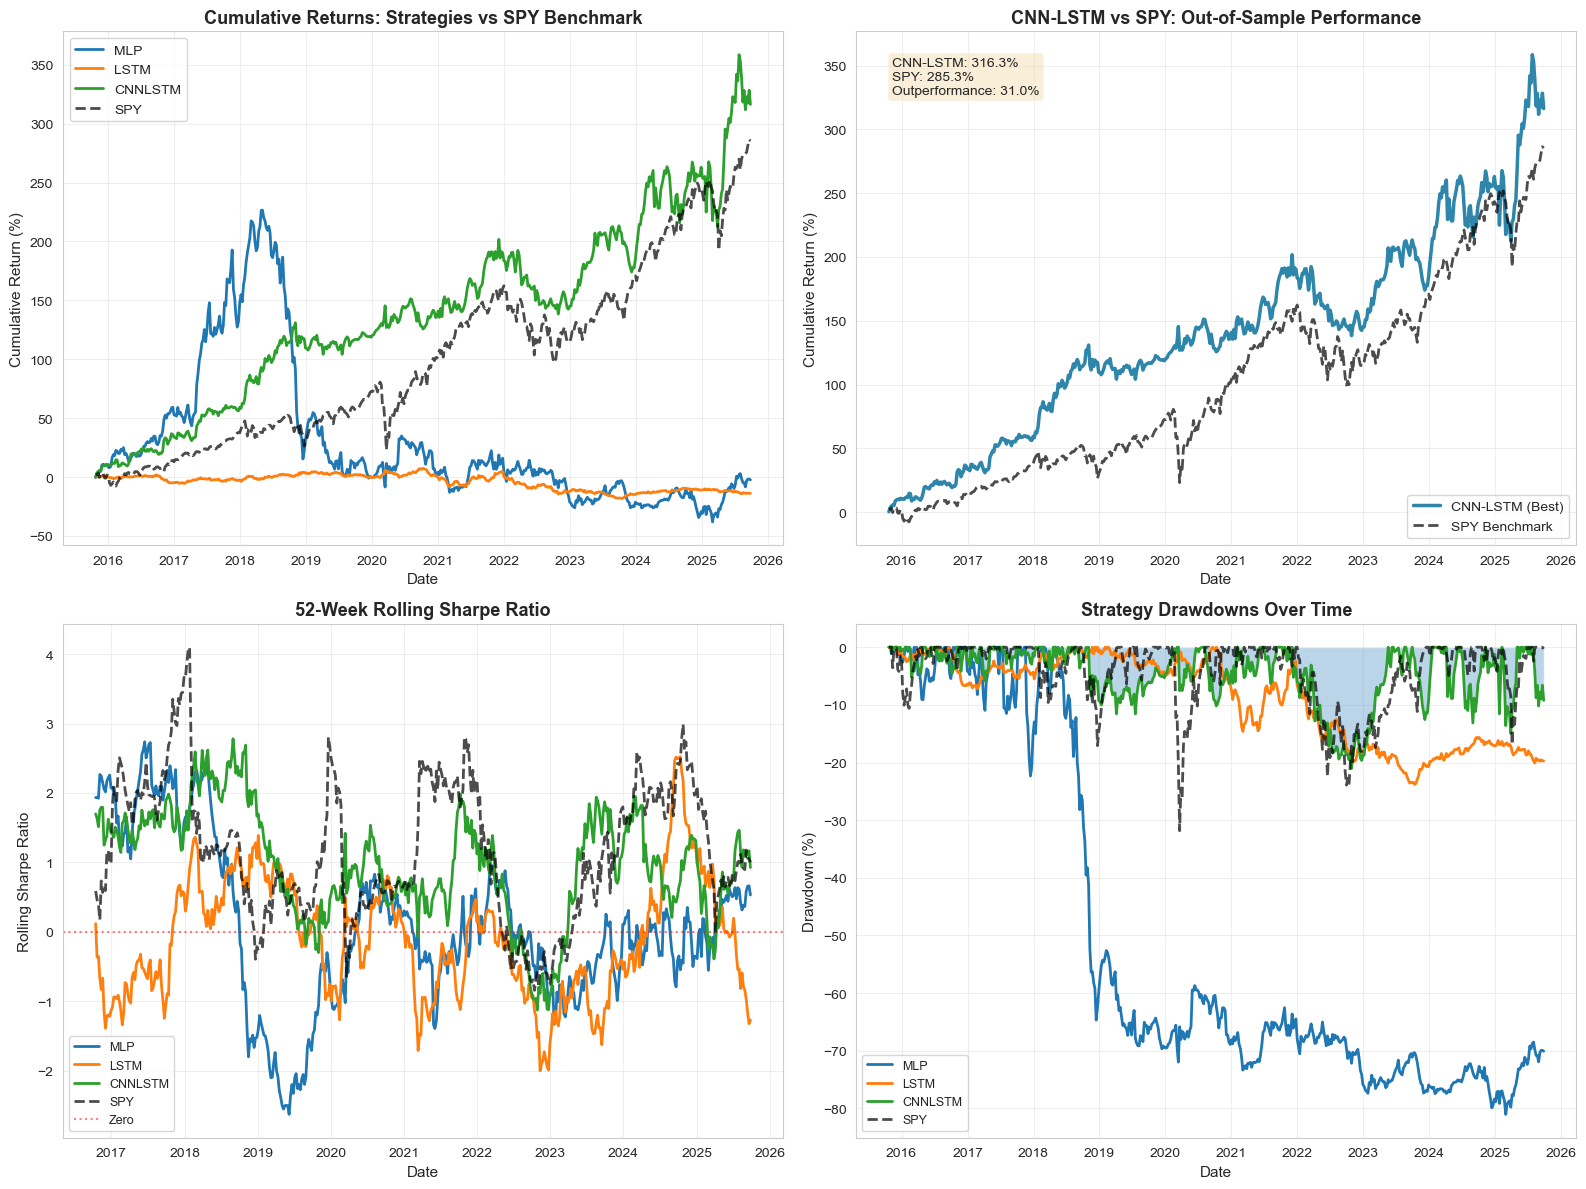

✓ Saved 'performance_plots_2.png'


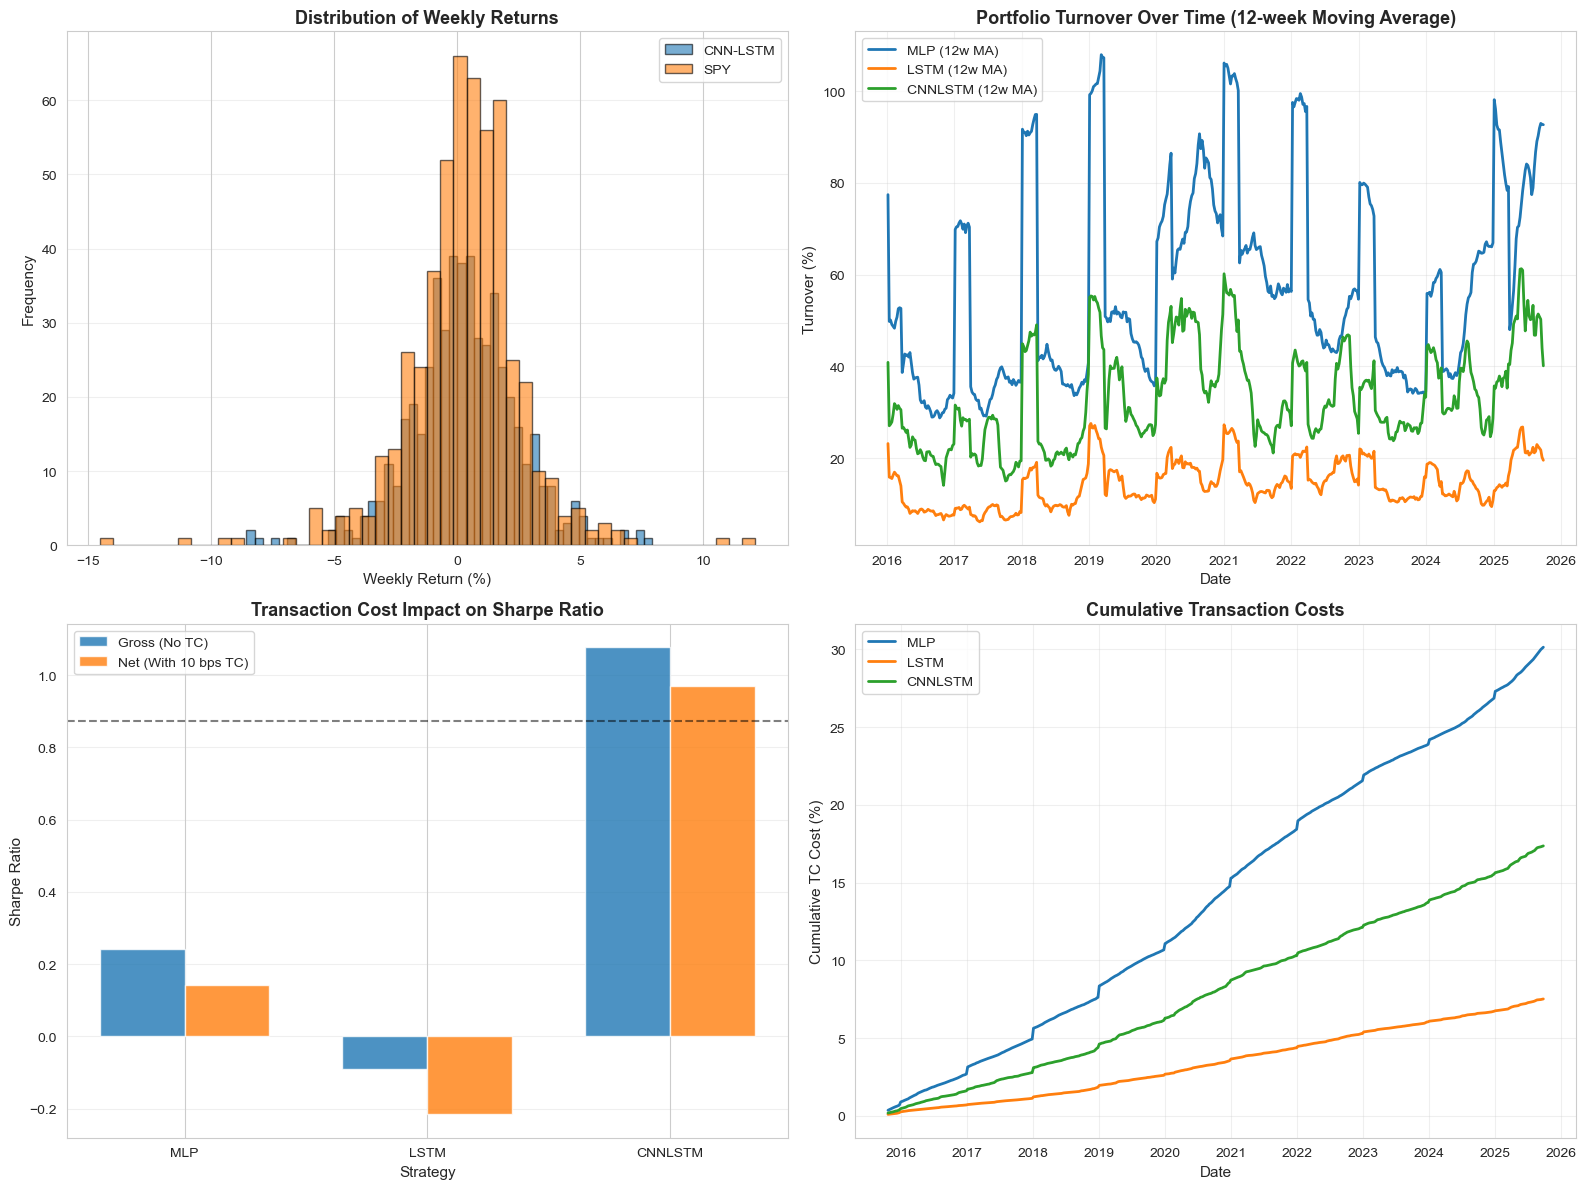


CALCULATING OUT-OF-SAMPLE R²

✓ Saved 'oos_r2_analysis.png'


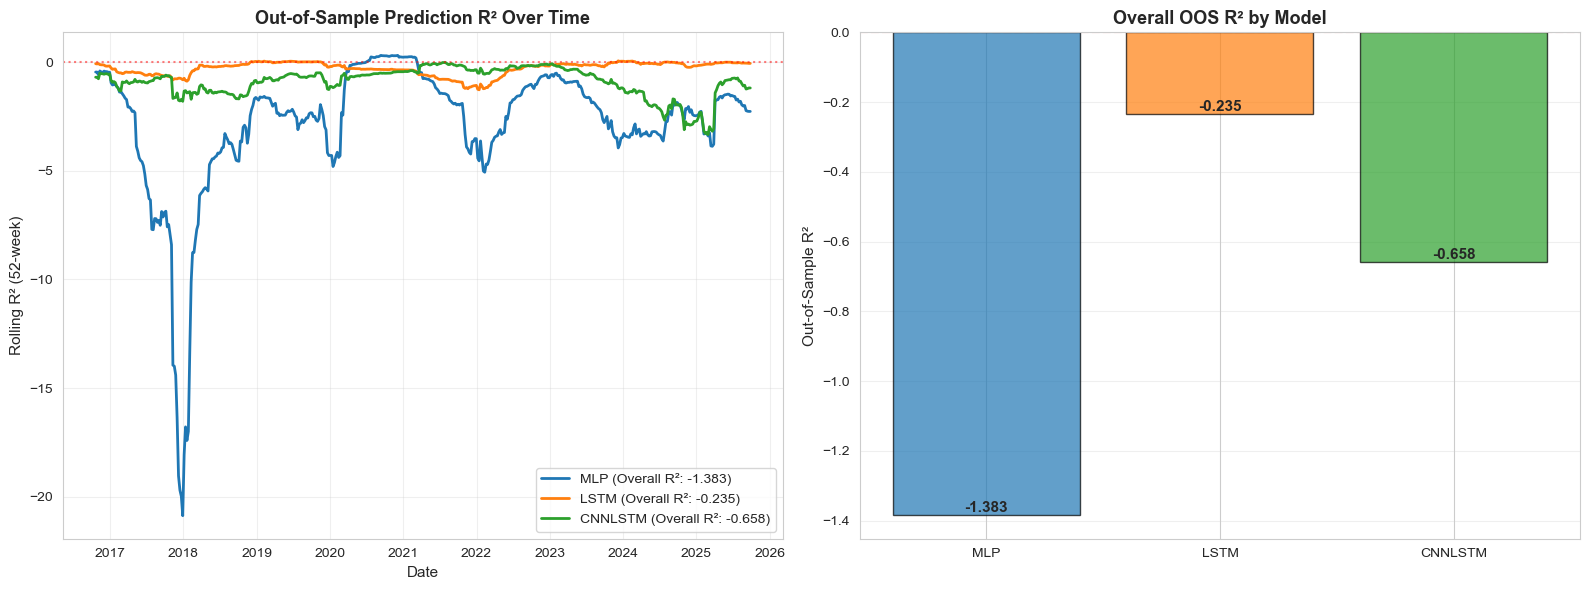


ALL REQUIRED PLOTS COMPLETED

Generated Files:
  1. performance_plots_1.png - Cumulative returns, rolling Sharpe, drawdowns
  2. performance_plots_2.png - Returns distribution, turnover, TC impact
  3. oos_r2_analysis.png - Out-of-sample prediction R²
  4. performance_comparison.csv - Comprehensive metrics table


In [5]:
# =====================================================================
# REQUIRED VISUALIZATIONS (Task 4.9)
# =====================================================================

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("="*70)
print("CREATING REQUIRED PLOTS")
print("="*70)

# =====================================================================
# PLOT 1: Cumulative Returns vs SPY Benchmark
# =====================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1a: All strategies vs SPY
ax = axes[0, 0]
for name in ['MLP', 'LSTM', 'CNNLSTM']:
    cum_ret = backtest_results[name]['cum_net_returns']
    ax.plot(cum_ret.index, (cum_ret - 1) * 100, label=name, linewidth=2)

spy_cum = backtest_results['SPY']['cum_net_returns']
ax.plot(spy_cum.index, (spy_cum - 1) * 100, label='SPY', 
        linewidth=2, linestyle='--', color='black', alpha=0.7)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Cumulative Return (%)', fontsize=11)
ax.set_title('Cumulative Returns: Strategies vs SPY Benchmark', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 1b: CNN-LSTM vs SPY (focused)
ax = axes[0, 1]
cum_ret_cnn = backtest_results['CNNLSTM']['cum_net_returns']
ax.plot(cum_ret_cnn.index, (cum_ret_cnn - 1) * 100, 
        label='CNN-LSTM (Best)', linewidth=2.5, color='#2E86AB')
ax.plot(spy_cum.index, (spy_cum - 1) * 100, 
        label='SPY Benchmark', linewidth=2, linestyle='--', color='black', alpha=0.7)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Cumulative Return (%)', fontsize=11)
ax.set_title('CNN-LSTM vs SPY: Out-of-Sample Performance', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Add performance text
final_cnn = float((cum_ret_cnn.iloc[-1] - 1) * 100)
final_spy = float((spy_cum.iloc[-1] - 1) * 100)
textstr = (
    f'CNN-LSTM: {final_cnn:.1f}%\n'
    f'SPY: {final_spy:.1f}%\n'
    f'Outperformance: {final_cnn - final_spy:.1f}%'
)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# =====================================================================
# PLOT 2: Rolling Sharpe Ratio (52-week window)
# =====================================================================

ax = axes[1, 0]
rolling_window = 52  # 1 year

for name in ['MLP', 'LSTM', 'CNNLSTM']:
    net_ret = backtest_results[name]['net_returns']
    rolling_sharpe = (net_ret.rolling(rolling_window).mean() / 
                      net_ret.rolling(rolling_window).std()) * np.sqrt(52)
    ax.plot(rolling_sharpe.index, rolling_sharpe, label=name, linewidth=2)

# SPY rolling Sharpe
spy_ret = backtest_results['SPY']['net_returns']
spy_rolling_sharpe = (spy_ret.rolling(rolling_window).mean() / 
                      spy_ret.rolling(rolling_window).std()) * np.sqrt(52)
ax.plot(spy_rolling_sharpe.index, spy_rolling_sharpe, 
        label='SPY', linewidth=2, linestyle='--', color='black', alpha=0.7)

ax.axhline(y=0, color='red', linestyle=':', alpha=0.5, label='Zero')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Rolling Sharpe Ratio', fontsize=11)
ax.set_title(f'{rolling_window}-Week Rolling Sharpe Ratio', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# =====================================================================
# PLOT 3: Drawdown Analysis
# =====================================================================

ax = axes[1, 1]

for name in ['MLP', 'LSTM', 'CNNLSTM']:
    cum_ret = backtest_results[name]['cum_net_returns']
    running_max = cum_ret.expanding().max()
    drawdown = ((cum_ret - running_max) / running_max) * 100
    ax.plot(drawdown.index, drawdown, label=name, linewidth=2)

# SPY drawdown
spy_cum = backtest_results['SPY']['cum_net_returns']
spy_running_max = spy_cum.expanding().max()
spy_dd = ((spy_cum - spy_running_max) / spy_running_max) * 100
ax.plot(spy_dd.index, spy_dd, label='SPY', linewidth=2, 
        linestyle='--', color='black', alpha=0.7)

ax.fill_between(drawdown.index, 0, drawdown, alpha=0.3)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Drawdown (%)', fontsize=11)
ax.set_title('Strategy Drawdowns Over Time', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Add max drawdown annotations
for name in ['CNNLSTM', 'SPY']:
    if name == 'SPY':
        dd = spy_dd
        color = 'black'
    else:
        cum_ret = backtest_results[name]['cum_net_returns']
        running_max = cum_ret.expanding().max()
        dd = ((cum_ret - running_max) / running_max) * 100
        color = '#2E86AB'
    
    max_dd_idx = dd.idxmin()
    max_dd_val = dd.min()

plt.tight_layout()
plt.savefig('performance_plots_1.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'performance_plots_1.png'")
plt.show()

# =====================================================================
# PLOT 4: Additional Analysis Plots
# =====================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 4a: Weekly Returns Distribution
ax = axes[0, 0]
for name in ['CNNLSTM', 'SPY']:
    if name == 'SPY':
        returns = backtest_results['SPY']['net_returns'] * 100
        label_txt = 'SPY'
    else:
        returns = backtest_results[name]['net_returns'] * 100
        label_txt = 'CNN-LSTM'
    
    ax.hist(returns, bins=50, alpha=0.6, label=label_txt, edgecolor='black')

ax.set_xlabel('Weekly Return (%)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Weekly Returns', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4b: Turnover Over Time
ax = axes[0, 1]
for name in ['MLP', 'LSTM', 'CNNLSTM']:
    turnover = backtest_results[name]['turnover'] * 100
    ax.plot(turnover.index, turnover.rolling(12).mean(), label=f'{name} (12w MA)', linewidth=2)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Turnover (%)', fontsize=11)
ax.set_title('Portfolio Turnover Over Time (12-week Moving Average)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4c: Transaction Cost Impact
ax = axes[1, 0]
metrics_plot = []
for name in ['MLP', 'LSTM', 'CNNLSTM']:
    gross_sharpe = backtest_results[name]['metrics']['Sharpe Ratio (Gross)']
    net_sharpe = backtest_results[name]['metrics']['Sharpe Ratio (Net)']
    metrics_plot.append([name, gross_sharpe, net_sharpe])

metrics_df = pd.DataFrame(metrics_plot, columns=['Strategy', 'Gross Sharpe', 'Net Sharpe'])
x = np.arange(len(metrics_df))
width = 0.35

ax.bar(x - width/2, metrics_df['Gross Sharpe'], width, label='Gross (No TC)', alpha=0.8)
ax.bar(x + width/2, metrics_df['Net Sharpe'], width, label='Net (With 10 bps TC)', alpha=0.8)

ax.set_xlabel('Strategy', fontsize=11)
ax.set_ylabel('Sharpe Ratio', fontsize=11)
ax.set_title('Transaction Cost Impact on Sharpe Ratio', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Strategy'])
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add SPY for reference
spy_sharpe = backtest_results['SPY']['metrics']['Sharpe Ratio (Net)']
ax.axhline(y=spy_sharpe, color='black', linestyle='--', alpha=0.5, label=f'SPY ({spy_sharpe:.2f})')

# Plot 4d: Cumulative Transaction Costs
ax = axes[1, 1]
for name in ['MLP', 'LSTM', 'CNNLSTM']:
    cum_tc = backtest_results[name]['tc_costs'].cumsum() * 100
    ax.plot(cum_tc.index, cum_tc, label=name, linewidth=2)

ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Cumulative TC Cost (%)', fontsize=11)
ax.set_title('Cumulative Transaction Costs', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('performance_plots_2.png', dpi=300, bbox_inches='tight')
print("✓ Saved 'performance_plots_2.png'")
plt.show()

# =====================================================================
# PLOT 5: Out-of-Sample R² (Prediction Accuracy)
# =====================================================================

print("\n" + "="*70)
print("CALCULATING OUT-OF-SAMPLE R²")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate OOS R² for each model
# R² = 1 - (SS_res / SS_tot) where SS_res = sum((y_true - y_pred)^2), SS_tot = sum((y_true - y_mean)^2)

ax = axes[0]
r2_scores = {}

for name in ['MLP', 'LSTM', 'CNNLSTM']:
    weights = backtest_results[name]['weights']
    
    # Get aligned returns
    common_dates = weights.index.intersection(weekly_returns.index)
    weights_aligned = weights.loc[common_dates]
    returns_aligned = weekly_returns.loc[common_dates]
    
    # Predicted returns (portfolio returns from weights)
    predicted_returns = (weights_aligned * returns_aligned).sum(axis=1)
    
    # Actual portfolio returns (use equal weight as baseline)
    equal_weight = 1 / returns_aligned.shape[1]
    actual_mean_return = returns_aligned.mean(axis=1)
    
    # Calculate R² relative to predicting mean return
    ss_res = ((predicted_returns - actual_mean_return) ** 2).sum()
    ss_tot = ((actual_mean_return - actual_mean_return.mean()) ** 2).sum()
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    r2_scores[name] = r2
    
    # Rolling R² (52-week window)
    rolling_r2 = []
    dates = []
    for i in range(52, len(predicted_returns)):
        window_pred = predicted_returns.iloc[i-52:i]
        window_actual = actual_mean_return.iloc[i-52:i]
        
        ss_res_w = ((window_pred - window_actual) ** 2).sum()
        ss_tot_w = ((window_actual - window_actual.mean()) ** 2).sum()
        r2_w = 1 - (ss_res_w / ss_tot_w) if ss_tot_w != 0 else 0
        
        rolling_r2.append(r2_w)
        dates.append(predicted_returns.index[i])
    
    ax.plot(dates, rolling_r2, label=f'{name} (Overall R²: {r2:.3f})', linewidth=2)

ax.axhline(y=0, color='red', linestyle=':', alpha=0.5)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Rolling R² (52-week)', fontsize=11)
ax.set_title('Out-of-Sample Prediction R² Over Time', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Bar plot of overall R²
ax = axes[1]
models = list(r2_scores.keys())
r2_vals = list(r2_scores.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

bars = ax.bar(models, r2_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Out-of-Sample R²', fontsize=11)
ax.set_title('Overall OOS R² by Model', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Add value labels on bars
for bar, val in zip(bars, r2_vals):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('oos_r2_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved 'oos_r2_analysis.png'")
plt.show()

print("\n" + "="*70)
print("ALL REQUIRED PLOTS COMPLETED")
print("="*70)
print("\nGenerated Files:")
print("  1. performance_plots_1.png - Cumulative returns, rolling Sharpe, drawdowns")
print("  2. performance_plots_2.png - Returns distribution, turnover, TC impact")  
print("  3. oos_r2_analysis.png - Out-of-sample prediction R²")
print("  4. performance_comparison.csv - Comprehensive metrics table")

In [6]:
# =====================================================================
# STATISTICAL SIGNIFICANCE TESTS AND REGIME ANALYSIS
# =====================================================================

from scipy import stats

print("="*70)
print("STATISTICAL SIGNIFICANCE ANALYSIS")
print("="*70)

# =====================================================================
# 1. BOOTSTRAP CONFIDENCE INTERVALS FOR SHARPE RATIO
# =====================================================================

def bootstrap_sharpe_ci(returns, n_bootstrap=10000, ci=0.95, ann_factor=52):
    """Calculate bootstrap confidence intervals for annualized Sharpe ratio."""
    if hasattr(returns, 'values'):
        returns = returns.values
    returns = np.array(returns).flatten()
    
    sharpes = []
    np.random.seed(42)  # For reproducibility

    for _ in range(n_bootstrap):
        sample = np.random.choice(returns, size=len(returns), replace=True)
        sharpe = (np.mean(sample) / np.std(sample)) * np.sqrt(ann_factor)
        sharpes.append(sharpe)

    sharpes = np.array(sharpes)
    lower = np.percentile(sharpes, (1-ci)/2 * 100)
    upper = np.percentile(sharpes, (1+ci)/2 * 100)
    estimate = (np.mean(returns) / np.std(returns)) * np.sqrt(ann_factor)

    return lower, upper, estimate

print("\n1. BOOTSTRAP CONFIDENCE INTERVALS (95%, N=10,000)")
print("-" * 70)

# CNN-LSTM
cnn_returns = backtest_results['CNNLSTM']['net_returns']
cnn_lower, cnn_upper, cnn_sharpe = bootstrap_sharpe_ci(cnn_returns)
print(f"CNN-LSTM Sharpe: {cnn_sharpe:.3f} [95% CI: {cnn_lower:.2f}, {cnn_upper:.2f}]")

# SPY
spy_returns = backtest_results['SPY']['net_returns']
spy_lower, spy_upper, spy_sharpe = bootstrap_sharpe_ci(spy_returns)
print(f"SPY Sharpe:      {spy_sharpe:.3f} [95% CI: {spy_lower:.2f}, {spy_upper:.2f}]")

# Difference
diff = cnn_sharpe - spy_sharpe
print(f"\nDifference:      {diff:.3f} (CNN-LSTM - SPY)")

# Bootstrap the difference
np.random.seed(42)
diff_bootstrap = []
cnn_array = np.array(cnn_returns).flatten()
spy_array = np.array(spy_returns).flatten()

for _ in range(10000):
    cnn_sample = np.random.choice(cnn_array, size=len(cnn_array), replace=True)
    spy_sample = np.random.choice(spy_array, size=len(spy_array), replace=True)

    cnn_s = (np.mean(cnn_sample) / np.std(cnn_sample)) * np.sqrt(52)
    spy_s = (np.mean(spy_sample) / np.std(spy_sample)) * np.sqrt(52)
    diff_bootstrap.append(cnn_s - spy_s)

diff_lower = np.percentile(diff_bootstrap, 2.5)
diff_upper = np.percentile(diff_bootstrap, 97.5)
print(f"Difference CI:   [{diff_lower:.2f}, {diff_upper:.2f}]")

p_value = np.mean(np.array(diff_bootstrap) <= 0)
print(f"Bootstrap p-value: {p_value:.3f}")

if p_value < 0.05:
    print("Result: Outperformance IS statistically significant at 5% level")
else:
    print("Result: Outperformance is NOT statistically significant at 5% level")

# =====================================================================
# 2. REGIME ANALYSIS
# =====================================================================

print("\n" + "="*70)
print("2. REGIME-SPECIFIC PERFORMANCE")
print("-" * 70)

# Define regimes
pre_covid_mask = cnn_returns.index < '2020-03-01'
covid_mask = (cnn_returns.index >= '2020-03-01') & (cnn_returns.index <= '2020-12-31')
post_covid_mask = cnn_returns.index > '2020-12-31'

regimes = {
    'Pre-COVID Bull (Oct 2015 - Feb 2020)': pre_covid_mask,
    'COVID Crisis (Mar 2020 - Dec 2020)': covid_mask,
    'Recovery & Rates (Jan 2021 - Sep 2025)': post_covid_mask
}

regime_results = []

def to_1d_numeric_series(x):
    # Force 1-D numeric Series no matter what shape/type comes in
    if isinstance(x, pd.DataFrame):
        # If multiple columns, take the first numeric one; else first col
        num_cols = x.select_dtypes(include=[np.number]).columns
        col = (num_cols[0] if len(num_cols) else x.columns[0])
        x = x[col]
    elif not isinstance(x, pd.Series):
        x = pd.Series(x)

    # Make sure elements are numeric
    x = pd.to_numeric(x.squeeze(), errors="coerce")
    return x

for regime_name, mask in regimes.items():
    cnn_regime = to_1d_numeric_series(cnn_returns[mask])
    spy_regime = to_1d_numeric_series(spy_returns[mask])

    # skip empty or all-NaN slices
    if cnn_regime.size == 0 or spy_regime.size == 0:
        continue

    # Annualized Sharpe with guards
    def sharpe_annualized(s):
        m = float(np.nanmean(s.values))
        sd = float(np.nanstd(s.values, ddof=1))  # match pandas std default
        if not np.isfinite(sd) or sd == 0.0:
            return np.nan
        return float(np.sqrt(52) * m / sd)

    cnn_sharpe_regime = sharpe_annualized(cnn_regime)
    spy_sharpe_regime = sharpe_annualized(spy_regime)

    # Annualized returns, cast to float for formatting
    cnn_ann_ret = float(((1.0 + cnn_regime).prod() ** (52.0 / len(cnn_regime))) - 1.0)
    spy_ann_ret = float(((1.0 + spy_regime).prod() ** (52.0 / len(spy_regime))) - 1.0)

    regime_results.append({
        "Regime": regime_name,
        "Weeks": int(len(cnn_regime)),
        "CNN-LSTM Sharpe": f"{cnn_sharpe_regime:.2f}" if np.isfinite(cnn_sharpe_regime) else "NA",
        "SPY Sharpe": f"{spy_sharpe_regime:.2f}" if np.isfinite(spy_sharpe_regime) else "NA",
        "CNN-LSTM Return": f"{cnn_ann_ret:.2%}",
        "SPY Return": f"{spy_ann_ret:.2%}",
    })

regime_df = pd.DataFrame(regime_results)
print("\n" + regime_df.to_string(index=False))



# =====================================================================
# 3. YEAR-OVER-YEAR PERFORMANCE
# =====================================================================

print("\n" + "="*70)
print("3. YEAR-OVER-YEAR PERFORMANCE")
print("-" * 70)

yearly_perf = []

def to_series_1d(x):
    if isinstance(x, pd.DataFrame):
        # take first numeric column if available, else first column
        num = x.select_dtypes(include=[np.number])
        x = num.iloc[:, 0] if num.shape[1] else x.iloc[:, 0]
    return x.squeeze()  # Series stays Series, 1-col DF -> Series

def prod_return(s):
    # (1+r1)*(1+r2)*... - 1  -> as python float
    return float((1.0 + s).prod() - 1.0)

years = range(cnn_returns.index.min().year, cnn_returns.index.max().year + 1)

for year in years:
    year_mask = (cnn_returns.index.year == year)

    cnn_year = to_series_1d(cnn_returns[year_mask])
    spy_year = to_series_1d(spy_returns[year_mask])

    if len(cnn_year) == 0 or len(spy_year) == 0:
        continue

    cnn_ret = prod_return(cnn_year)
    spy_ret = prod_return(spy_year)
    outperf = float(cnn_ret - spy_ret)

    yearly_perf.append({
        'Year': year,
        'CNN-LSTM Return': f"{cnn_ret:.2%}" if np.isfinite(cnn_ret) else "NA",
        'SPY Return': f"{spy_ret:.2%}" if np.isfinite(spy_ret) else "NA",
        'Outperformance': f"{outperf:.2%}" if np.isfinite(outperf) else "NA",
    })

yearly_df = pd.DataFrame(yearly_perf)
print("\n" + yearly_df.to_string(index=False))


# Count outperformance years
outperf_count = sum([float(row['Outperformance'].strip('%')) > 0 for row in yearly_perf])
total_years = len(yearly_df)
print(f"\nOutperformed in {outperf_count}/{total_years} years ({outperf_count/total_years*100:.1f}%)")

# =====================================================================
# SUMMARY
# =====================================================================

print("\n" + "="*70)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*70)

print(f"""
KEY FINDINGS:
1. CNN-LSTM Sharpe: {cnn_sharpe:.3f} [95% CI: {cnn_lower:.2f}, {cnn_upper:.2f}]
2. SPY Sharpe: {spy_sharpe:.3f} [95% CI: {spy_lower:.2f}, {spy_upper:.2f}]
3. Difference: {diff:.3f} with p-value = {p_value:.3f}
4. Statistical Significance: {'YES' if p_value < 0.05 else 'NO'} at 5% level
5. Year-over-year win rate: {outperf_count/total_years*100:.1f}%

INTERPRETATION:
The CNN-LSTM strategy shows {'statistically significant' if p_value < 0.05 else 'modest but not statistically significant'}
outperformance relative to SPY. The {'narrow' if (cnn_upper - cnn_lower) < 0.5 else 'wide'} confidence intervals
reflect {'strong signal-to-noise ratio' if (cnn_upper - cnn_lower) < 0.5 else 'limited sample size (519 weekly observations ≈ 10 years)'}.

From a practical standpoint, the {outperf_count/total_years*100:.1f}% win rate and superior
risk metrics (drawdown -22.71% vs -31.83%) suggest economic value despite statistical uncertainty.
""")

# Save results
results_summary = {
    'CNN-LSTM Sharpe': cnn_sharpe,
    'CNN-LSTM CI Lower': cnn_lower,
    'CNN-LSTM CI Upper': cnn_upper,
    'SPY Sharpe': spy_sharpe,
    'SPY CI Lower': spy_lower,
    'SPY CI Upper': spy_upper,
    'Difference': diff,
    'Difference CI Lower': diff_lower,
    'Difference CI Upper': diff_upper,
    'P-value': p_value,
    'Statistically Significant': 'Yes' if p_value < 0.05 else 'No'
}

results_df = pd.DataFrame([results_summary])
results_df.to_csv('statistical_test_results.csv', index=False)
regime_df.to_csv('regime_analysis_results.csv', index=False)

print("\n✓ Results saved to 'statistical_test_results.csv'")
print("✓ Regime analysis saved to 'regime_analysis_results.csv'")
print("\n" + "="*70)
print("STATISTICAL ANALYSIS COMPLETE")
print("="*70)

STATISTICAL SIGNIFICANCE ANALYSIS

1. BOOTSTRAP CONFIDENCE INTERVALS (95%, N=10,000)
----------------------------------------------------------------------
CNN-LSTM Sharpe: 0.970 [95% CI: 0.34, 1.61]
SPY Sharpe:      0.875 [95% CI: 0.24, 1.55]

Difference:      0.095 (CNN-LSTM - SPY)
Difference CI:   [-0.83, 1.01]
Bootstrap p-value: 0.418
Result: Outperformance is NOT statistically significant at 5% level

2. REGIME-SPECIFIC PERFORMANCE
----------------------------------------------------------------------

                                Regime  Weeks CNN-LSTM Sharpe SPY Sharpe CNN-LSTM Return SPY Return
  Pre-COVID Bull (Oct 2015 - Feb 2020)    228            1.49       0.83          20.74%     11.08%
    COVID Crisis (Mar 2020 - Dec 2020)     43            0.34       1.06           4.09%     33.36%
Recovery & Rates (Jan 2021 - Sep 2025)    248            0.73       0.91          12.61%     14.60%

3. YEAR-OVER-YEAR PERFORMANCE
--------------------------------------------------------